In [1]:
#Importing libraries
from typing import List, Tuple
import numpy as np
import pandas as pd
from typing import List, Optional
from tqdm import tqdm
from sklearn.utils.validation import check_is_fitted
import xgboost as xgb
import catboost as catb
from catboost.utils import get_roc_curve
from catboost import Pool
import lightgbm as lgb

import os
import json
import shap
import dill
import matplotlib.pyplot as plt
from collections import Counter
from PIL import  Image
import missingno as msno
%matplotlib inline

import seaborn as sns #visualization
import itertools
import warnings
warnings.filterwarnings("ignore")
import io
import plotly.offline as py#visualization
py.init_notebook_mode(connected=True)#visualization
import plotly.graph_objs as go#visualization
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization

from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.model_selection import train_test_split, TimeSeriesSplit, KFold, StratifiedKFold, GroupKFold
from scipy.stats import shapiro, probplot, ttest_ind, mannwhitneyu, chi2_contingency, ks_2samp
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, scorer, log_loss
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, f1_score, cohen_kappa_score
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder as le
from pylab import rcParams

rcParams['figure.figsize'] = 8, 5
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 400)
plt.style.use('seaborn-whitegrid')
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.5))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [3]:
def plot_roc_curve(**kwargs):
    res_lst = []
    
    for k, v in kwargs.items():  
        fpr, tpr, _ = roc_curve(v[0], v[1])
        res_lst.append((fpr, tpr, k))
    
    plt.figure(figsize=(20,10))
    for res in res_lst:
        plt.plot(res[0], res[1], label=res[2])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend()
    plt.show()
    
    return res_lst

In [4]:
#Загружаю частично обработанный мною от пропусков в ДЗ2 датасет:
# train = pd.read_csv("assignment2_data/assignment_2_train.csv")
train = pd.read_csv("assignment2_data/train2.csv")
lb = pd.read_csv("assignment2_data/assignment_2_test.csv")

print("train.shape = {} rows, {} cols".format(*train.shape))
print("train.shape = {} rows, {} cols".format(*lb.shape))

train.shape = 179977 rows, 398 cols
train.shape = 100001 rows, 394 cols


In [5]:
train.head(2)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,P_emaildomain_zone,R_emaildomain_zone,P_emaildomain_domain,R_emaildomain_domain
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,unknown,unknown,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,unknown,unknown,unknown,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unknown,unknown,unknown,unknown
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,unknown,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,unknown,unknown,unknown,M0,T,T,unknown,unknown,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [6]:
train.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
count,1.799770e+05,179977.000000,1.799770e+05,179977.000000,179977.000000,177374.000000,179977.000000,179039.000000,160548.000000,160548.000000,60602.000000,14456.000000,179977.000000,179977.000000,179977.000000,179977.000000,179977.000000,179977.000000,179977.000000,179977.000000,179977.000000,179977.000000,179977.000000,179977.000000,179977.000000,179977.000000,179977.000000,80298.000000,83032.000000,106914.000000,68744.000000,24230.000000,11671.000000,33590.000000,33590.000000,134325.000000,59096.000000,20798.000000,18666.000000,20543.000000,131168.000000,59096.000000,59096.000000,59096.000000,59096.000000,59096.000000,59096.000000,59096.000000,59096.000000,59096.000000,59096.000000,59096.000000,134312.000000,134312.000000,134312.000000,134312.000000,134312.000000,134312.000000,134312.000000,134312.000000,134312.000000,134312.000000,134312.000000,134312.000000,134312.000000,134312.000000,134312.000000,134312.000000,134312.000000,134312.000000,134312.000000,134312.000000,134312.000000,134312.000000,134312.000000,106908.000000,106908.000000,106908.000000,106908.000000,106908.000000,106908.000000,106908.000000,106908.000000,106908.000000,106908.000000,106908.000000,106908.000000,106908.000000,106908.000000,106908.000000,106908.000000,106908.000000,106908.000000,134083.000000,134083.000000,134083.000000,134083.000000,134083.000000,134083.000000,134083.000000,134083.000000,134083.000000,134083.000000,134083.000000,134083.000000,134083.000000,134083.000000,134083.000000,134083.000000,134083.000000,134083.000000,134083.000000,134083.000000,134083.000000,134083.000000,131160.000000,131160.000000,131160.000000,131160.000000,131160.000000,131160.000000,131160.000000,131160.000000,131160.000000,131160.000000,131160.000000,131160.000000,131160.000000,131160.000000,131160.000000,131160.000000,131160.000000,131160.000000,131160.000000,131160.000000,179977.000000,179977.000000,179977.000000,179977.000000,179977.000000,179977.000000,179977.000000,179977.000000,179977.000000,179977.000000,179977.000000,179977.000000,179977.0,179977.000000,179977.000000,179977.000000,179977.000000,179977.000000,179977.000000,179977.000000,179977.000000,179977.000000,179977.000000,179977.000000,179977.000000,

In [7]:
#Разбиваем признаки по типам: числовые, нечисловые, цель
num_features = train.select_dtypes("number").columns.to_list()
dum_features = train.select_dtypes("object").columns.to_list()
target = num_features.pop(1)
len(num_features), len(dum_features), target

(379, 18, 'isFraud')

#### Подготовка лидерборда для получения оценок метрики качества на нем:

Добавляю новые признаки в датасет лидерборда для получения результатов на нем:

In [8]:
lb.loc[lb['P_emaildomain']=='gmail', 'P_emaildomain'] = 'gmail.com'
lb.loc[lb['R_emaildomain']=='gmail', 'R_emaildomain'] = 'gmail.com'
lb['P_emaildomain'].fillna('unknown', inplace=True)
lb['R_emaildomain'].fillna('unknown', inplace=True)

lb['P_emaildomain_zone'] = lb['P_emaildomain'].apply(
    lambda x: '.'.join(x.split('.')[1:]) if x!='unknown' else 'unknown'
)
lb['R_emaildomain_zone'] = lb['R_emaildomain'].apply(
    lambda x: '.'.join(x.split('.')[1:]) if x!='unknown' else 'unknown'
)
lb['P_emaildomain_domain'] = lb['P_emaildomain'].apply(lambda x: x.split('.')[0])
lb['R_emaildomain_domain'] = lb['R_emaildomain'].apply(lambda x: x.split('.')[0])
print("train.shape = {} rows, {} cols".format(*lb.shape))

train.shape = 100001 rows, 398 cols


In [9]:
dum_na = lb[dum_features].isnull().sum()
col_na_lst = dum_na.loc[dum_na > 0].index.tolist()
lb[col_na_lst] = lb[col_na_lst].fillna('unknown')
lb[dum_features].isnull().sum()

ProductCD               0
card4                   0
card6                   0
P_emaildomain           0
R_emaildomain           0
M1                      0
M2                      0
M3                      0
M4                      0
M5                      0
M6                      0
M7                      0
M8                      0
M9                      0
P_emaildomain_zone      0
R_emaildomain_zone      0
P_emaildomain_domain    0
R_emaildomain_domain    0
dtype: int64

Датасет лидерборда для моделей:

In [10]:
y_lb = lb[target]
lb_train = lb[num_features + dum_features].apply(le().fit_transform)
dleaderboard = xgb.DMatrix(
    data=lb_train, label=y_lb
)

__Задание 1:__ сделать Hold-Out валидацию с разбиением, размер которого будет адеквтаным, по вашему мнению; разбиение проводить по id-транзакции (TransactionID), обучать модель градиетного бустинга любой реализации с подбором числа деревьев по early_stopping критерию до достижения сходимости. Оценить качество модели на валидационной выборке, оценить расхождение по сравнению с качеством на обучающей выборке и валидационной выборке. Оценить качество на ЛБ, сравнить с качеством на обучении и валидации. Сделать выводы.

In [11]:
data = train[num_features + dum_features].apply(le().fit_transform)

x_train, x_valid = train_test_split(
    data, train_size=0.8, random_state=1
)
y_train, y_valid = train_test_split(
    train[target], train_size=0.8, random_state=1
)
print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))

x_train.shape = 143981 rows, 397 cols
x_valid.shape = 35996 rows, 397 cols


In [12]:
params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.1,
#     "n_estimators": 1000,
    "reg_lambda": 100,
    "max_depth": 4,
    "gamma": 10,
    "nthread": 6,
    "seed": 27
}

In [117]:
dtrain = xgb.DMatrix(
    data=x_train, label=y_train
)
dvalid = xgb.DMatrix(
    data=x_valid, label=y_valid
)

In [118]:
%%time
model_xgb1 = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    early_stopping_rounds=50,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    verbose_eval=10,
    maximize=True,
)

[18:10:33] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.59074	valid-auc:0.56962
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[10]	train-auc:0.79613	valid-auc:0.78321
[20]	train-auc:0.82860	valid-auc:0.82071
[30]	train-auc:0.86592	valid-auc:0.86120
[40]	train-auc:0.87347	valid-auc:0.86718
[50]	train-auc:0.88536	valid-auc:0.88026
[60]	train-auc:0.89227	valid-auc:0.88526
[70]	train-auc:0.89763	valid-auc:0.88860
[80]	train-auc:0.90204	valid-auc:0.89211
[90]	train-auc:0.90545	valid-auc:0.89448
[100]	train-auc:0.90831	valid-auc:0.89660
[110]	train-auc:

In [120]:
y_train_pred = model_xgb1.predict(dtrain)
y_valid_pred = model_xgb1.predict(dvalid)
y_lb_pred = model_xgb1.predict(dleaderboard)

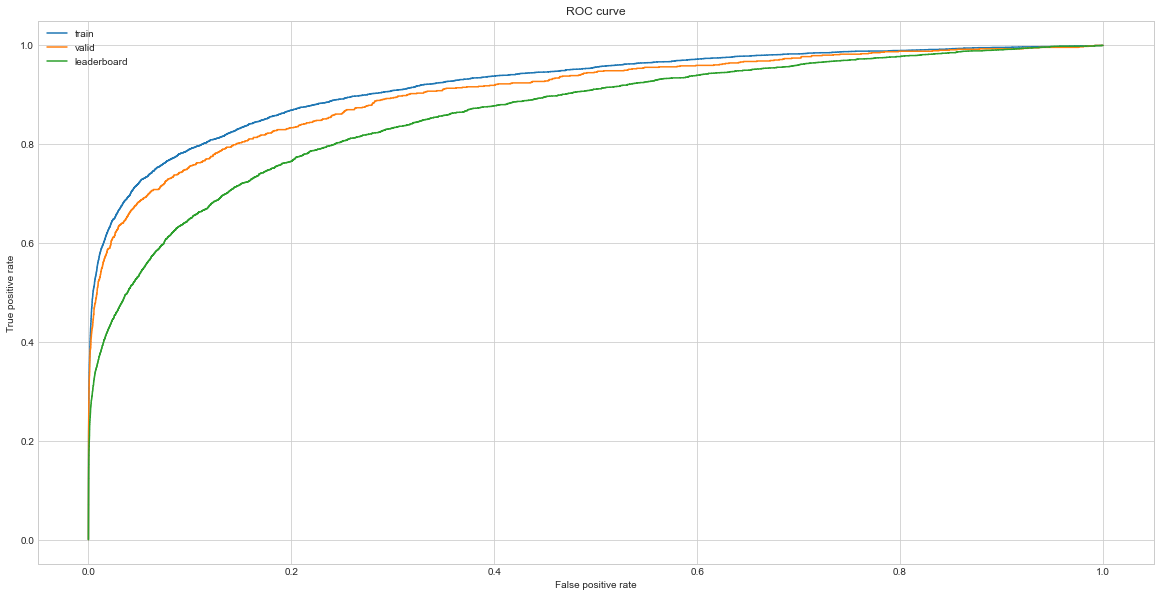

In [135]:
roc_curve_res = plot_roc_curve(
    train=(y_train, y_train_pred), 
    valid=(y_valid, y_valid_pred), 
    leaderboard=(y_lb, y_lb_pred)
)

In [136]:
print(
    'Train', roc_auc_score(y_train, y_train_pred), 
    '\nValid', roc_auc_score(y_valid, y_valid_pred), 
    '\nLeaderboard', roc_auc_score(y_lb, y_lb_pred)
)

Train 0.9205742151434633 
Valid 0.9045795022012654 
Leaderboard 0.861357081196428


- По графику уже видно, что модель переобучена, причем особенно сильно это заметно по сравнению с лидербордом. Подсчет метрики ROC AUC это дополнительно подтверждает.
- Но все же для целей соревнования пока еще рано говорить об этом с уверенностью. Посмотрим на других валидационных методах.

__Задание 2:__ сделать Hold-Out валидацию с разбиением на 3 выборки, разбиение проводить по id-транзакции (TransactionID), размер каждой выборки подобрать самостоятельно. Повторить процедуру из п.1. для каждой выборки.

In [137]:
data = train[num_features + dum_features].apply(le().fit_transform)

x_train, x_valid = train_test_split(
    data, train_size=0.75, random_state=1
)
y_train, y_valid = train_test_split(
    train[target], train_size=0.75, random_state=1
)

x_valid, x_test = train_test_split(
    x_valid, train_size=0.75, random_state=1
)
y_valid, y_test = train_test_split(
    y_valid, train_size=0.75, random_state=1
)

print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_test.shape))

x_train.shape = 134982 rows, 397 cols
x_valid.shape = 33746 rows, 397 cols
x_valid.shape = 11249 rows, 397 cols


In [138]:
dtrain = xgb.DMatrix(
    data=x_train, label=y_train
)
dvalid = xgb.DMatrix(
    data=x_valid, label=y_valid
)
dtest = xgb.DMatrix(
    data=x_test, label=y_test
)

In [139]:
%%time
model_xgb2 = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    early_stopping_rounds=50,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    verbose_eval=10,
    maximize=True,
)

[18:23:16] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.58816	valid-auc:0.56442
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[10]	train-auc:0.79116	valid-auc:0.77011
[20]	train-auc:0.82798	valid-auc:0.81399
[30]	train-auc:0.86326	valid-auc:0.85095
[40]	train-auc:0.87319	valid-auc:0.86270
[50]	train-auc:0.88450	valid-auc:0.87327
[60]	train-auc:0.89180	valid-auc:0.87843
[70]	train-auc:0.89748	valid-auc:0.88337
[80]	train-auc:0.90146	valid-auc:0.88670
[90]	train-auc:0.90563	valid-auc:0.88913
[100]	train-auc:0.90865	valid-auc:0.89110
[110]	train-auc:

In [140]:
y_train_pred = model_xgb2.predict(dtrain)
y_valid_pred = model_xgb2.predict(dvalid)
y_test_pred = model_xgb2.predict(dtest)
y_lb_pred = model_xgb2.predict(dleaderboard)

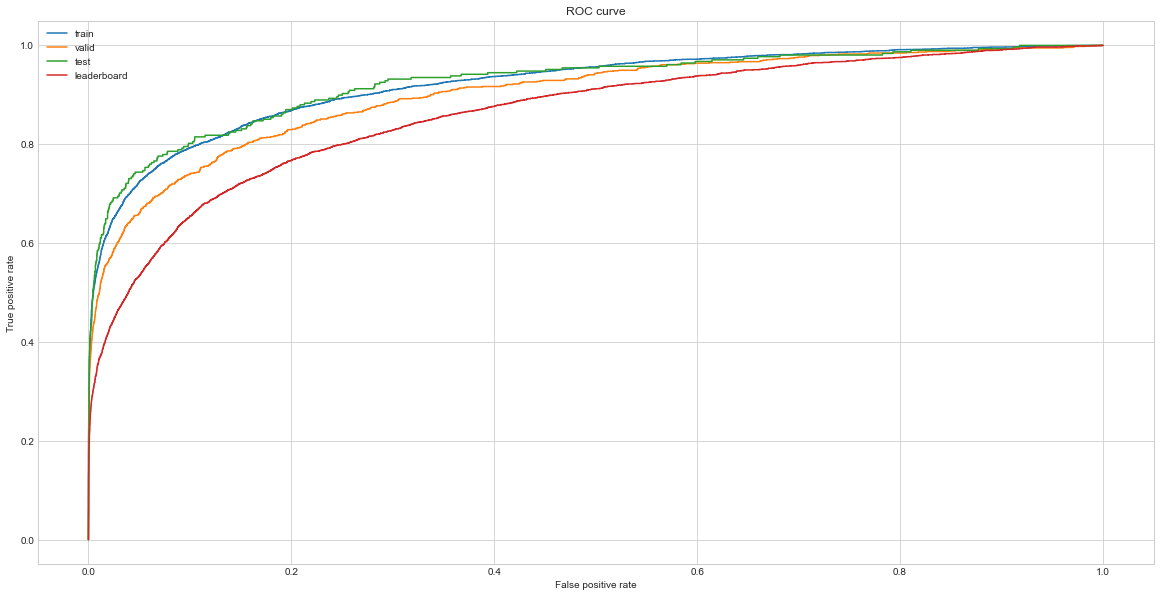

In [141]:
roc_curve_res = plot_roc_curve(
    train=(y_train, y_train_pred), 
    valid=(y_valid, y_valid_pred), 
    test=(y_test, y_test_pred), 
    leaderboard=(y_lb, y_lb_pred)
)

__Задание 3:__ построить доверительный интервал на данных из п.2 на основе бутстреп выборок, оценить качество модели на ЛБ относительно полученного доверительного интервала. Сделать выводы.

In [149]:
def create_bootstrap_samples(data: np.array, n_samples: int = 1000) -> np.array:
    """
    Создание бутстреп-выборок.

    Parameters
    ----------
    data: np.array
        Исходная выборка, которая будет использоваться для
        создания бутстреп выборок.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_idx: np.array
        Матрица индексов, для создания бутстреп выборок.

    """
    bootstrap_idx = np.random.randint(
        low=0, high=len(data), size=(n_samples, len(data))
    )
    return bootstrap_idx


def create_bootstrap_metrics(y_true: np.array,
                             y_pred: np.array,
                             metric: callable,
                             n_samlpes: int = 1000) -> List[float]:
    """
    Вычисление бутстреп оценок.

    Parameters
    ----------
    y_true: np.array
        Вектор целевой переменной.

    y_pred: np.array
        Вектор прогнозов.

    metric: callable
        Функция для вычисления метрики.
        Функция должна принимать 2 аргумента: y_true, y_pred.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_metrics: List[float]
        Список со значениями метрики качества на каждой бустреп выборке.

    """
    scores = []

    if isinstance(y_true, pd.Series):
        y_true = y_true.values

    bootstrap_idx = create_bootstrap_samples(y_true)
    for idx in bootstrap_idx:
        y_true_bootstrap = y_true[idx]
        y_pred_bootstrap = y_pred[idx]

        score = metric(y_true_bootstrap, y_pred_bootstrap)
        scores.append(score)

    return scores


def calculate_confidence_interval(scores: list, conf_interval: float = 0.95) -> Tuple[float]:
    """
    Вычисление доверительного интервала.

    Parameters
    ----------
    scores: List[float / int]
        Список с оценками изучаемой величины.

    conf_interval: float, optional, default = 0.95
        Уровень доверия для построения интервала.
        Опциональный параметр, по умолчанию, равен 0.95.

    Returns
    -------
    conf_interval: Tuple[float]
        Кортеж с границами доверительного интервала.

    """
    left_bound = np.percentile(
        scores, ((1 - conf_interval) / 2) * 100
    )
    right_bound = np.percentile(
        scores, (conf_interval + ((1 - conf_interval) / 2)) * 100
    )

    return left_bound, right_bound

In [150]:
np.random.seed(27)
scores = create_bootstrap_metrics(y_test, y_test_pred, roc_auc_score)

calculate_confidence_interval(scores)

(0.9040624606548564, 0.9424951426409784)

In [142]:
print(
    'Train', roc_auc_score(y_train, y_train_pred), 
    '\nValid', roc_auc_score(y_valid, y_valid_pred), 
    '\nTest', roc_auc_score(y_test, y_test_pred), 
    '\nLeaderboard', roc_auc_score(y_lb, y_lb_pred)
)

Train 0.9211304805569778 
Valid 0.9005790207296208 
Test 0.9238449262098837 
Leaderboard 0.8603375144877461


- Судя по тому, что результаты по лидерборду лежат за пределами доверительного интервала на тестовой выборке, значит модель действительно переобучена или же качество валидации не достаточно хорошее.

__Задание 4:__ выполнить Adversarial Validation, подобрать объекты из обучающей выборки, которые сильно похожи на объекты из assignment_2_test.csv, и использовать их в качестве валидационного набора. Оценить качество модели на ЛБ, сделать выводы о полученных результатах.

In [155]:
x_adv = pd.concat([
    data, lb_train], axis=0
)
y_adv = np.hstack((np.zeros(data.shape[0]), np.ones(lb_train.shape[0])))
assert x_adv.shape[0] == y_adv.shape[0]

In [158]:
dtrain = xgb.DMatrix(
    data=x_adv, label=y_adv
)

In [159]:
%%time
model_xgb3 = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    early_stopping_rounds=50,
    evals=[(dtrain, "train")],
    verbose_eval=10,
    maximize=True,
)

[19:01:10] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.99990	valid-auc:0.51780
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[10]	train-auc:0.99992	valid-auc:0.51780
[20]	train-auc:0.99998	valid-auc:0.51782
[30]	train-auc:0.99999	valid-auc:0.51783
[40]	train-auc:0.99999	valid-auc:0.51784
[50]	train-auc:1.00000	valid-auc:0.51724
[60]	train-auc:1.00000	valid-auc:0.51585
[70]	train-auc:1.00000	valid-auc:0.62359
[80]	train-auc:1.00000	valid-auc:0.62376
[90]	train-auc:1.00000	valid-auc:0.62377
[100]	train-auc:1.00000	valid-auc:0.62673
[110]	train-auc:

In [160]:
y_adv_pred = model_xgb3.predict(dtrain)
roc_auc_score(y_adv, y_adv_pred)

0.999999956522657

In [164]:
dtrain_real = xgb.DMatrix(
    data=data, label=np.zeros(data.shape[0])
)
y_pred = model_xgb3.predict(dtrain_real)

In [165]:
pd.cut(
    y_pred, bins=np.arange(0, 1.01, 0.1)
).value_counts().sort_index()

(0.0, 0.1]    179938
(0.1, 0.2]        24
(0.2, 0.3]         5
(0.3, 0.4]         0
(0.4, 0.5]         2
(0.5, 0.6]         1
(0.6, 0.7]         6
(0.7, 0.8]         1
(0.8, 0.9]         0
(0.9, 1.0]         0
dtype: int64

Трейн от теста модель легко отличает. Возможно, благодаря тому, что в обучении используются параметры "TransactionID" и "TransactionDT". Попробуем обучить модель без них:

In [172]:
x_adv = pd.concat([
    data.drop(['TransactionID', 'TransactionDT'], axis=1), lb_train.drop(['TransactionID', 'TransactionDT'], axis=1)], axis=0
)
y_adv = np.hstack((np.zeros(data.shape[0]), np.ones(lb_train.shape[0])))
assert x_adv.shape[0] == y_adv.shape[0]

In [173]:
dtrain = xgb.DMatrix(
    data=x_adv, label=y_adv
)

In [175]:
%%time
model_xgb4 = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    early_stopping_rounds=30,
    evals=[(dtrain, "train")],
    verbose_eval=10,
    maximize=True,
)

[20:09:21] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.99924
Will train until train-auc hasn't improved in 50 rounds.
[10]	train-auc:0.99999
[20]	train-auc:0.99999
[30]	train-auc:0.99999
[40]	train-auc:0.99999
[50]	train-auc:0.99999
[60]	train-auc:1.00000
[70]	train-auc:1.00000
[80]	train-auc:1.00000
[90]	train-auc:1.00000
[100]	train-auc:1.00000
Stopping. Best iteration:
[51]	train-auc:1.00000

Wall time: 2min 42s


In [177]:
dtrain_real = xgb.DMatrix(
    data=data.drop(['TransactionID', 'TransactionDT'], axis=1), label=np.zeros(data.shape[0])
)
y_pred = model_xgb4.predict(dtrain_real)

In [178]:
pd.cut(
    y_pred, bins=np.arange(0, 1.01, 0.1)
).value_counts().sort_index()

(0.0, 0.1]    179935
(0.1, 0.2]        21
(0.2, 0.3]         8
(0.3, 0.4]         7
(0.4, 0.5]         2
(0.5, 0.6]         1
(0.6, 0.7]         1
(0.7, 0.8]         1
(0.8, 0.9]         1
(0.9, 1.0]         0
dtype: int64

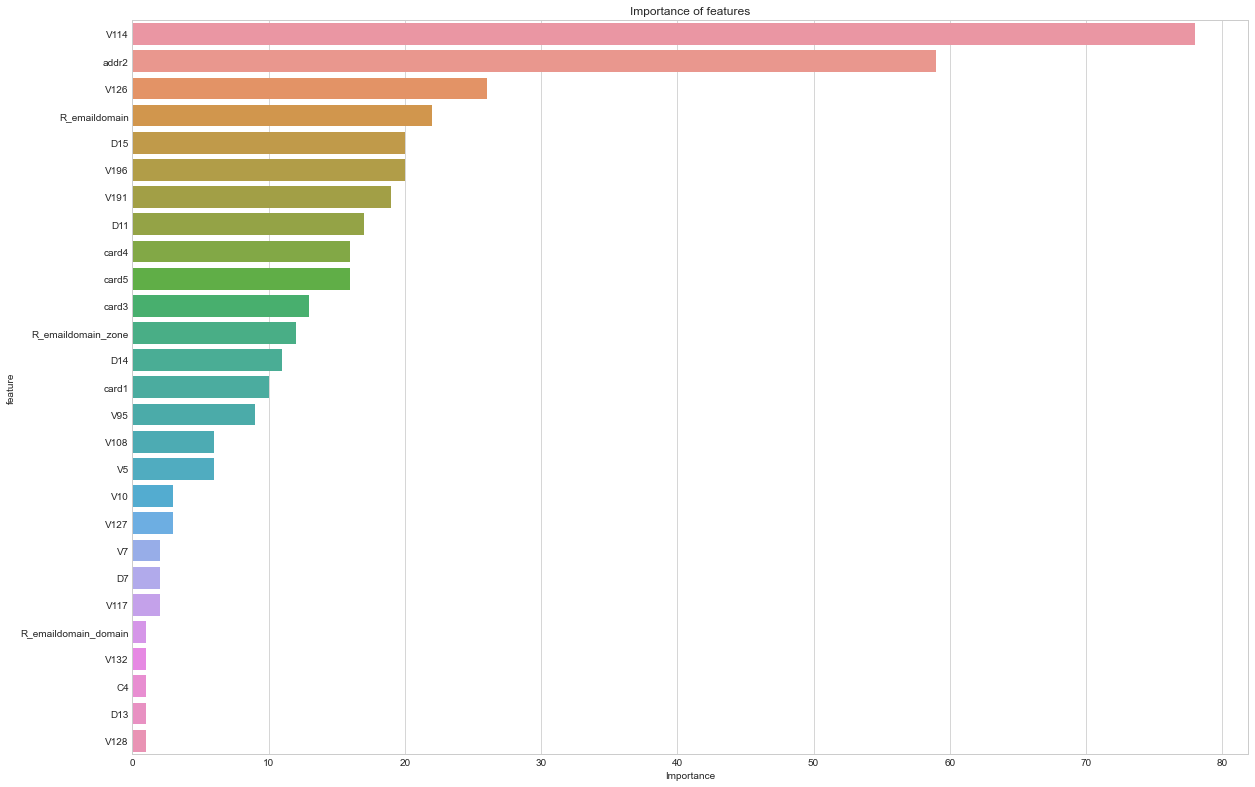

In [179]:
feature_important = model_xgb4.get_score(importance_type='weight')
top_feat = show_feature_importances(list(feature_important.keys()), list(feature_important.values()), get_top=30)

- Похоже, что по признакам V114, addr2, V126 и некоторым другим модель хорошо различает тренировочную и тестовую выборки. Поэтому в нашем случае эта методика валидации не подходит.

__Задание 5:__ сделать KFold / StratifiedKFold валидацию (на ваше усмотрение), оценить получаемые качество и разброс по метрике качества. Сделать выводы об устойчивости кросс-валидации, сходимости оценки на кросс-валидации и отложенном наборе данных; Оценить качество на ЛБ, сделать выводы.

In [38]:
def make_cross_validation(X: pd.DataFrame,
                          y: pd.Series,
                          estimator: object,
                          metric: callable,
                          cv_strategy,
                          groups: pd.Series = pd.Series()):
    """
    Кросс-валидация.

    Parameters
    ----------
    X: pd.DataFrame
        Матрица признаков.

    y: pd.Series
        Вектор целевой переменной.

    estimator: callable
        Объект модели для обучения.

    metric: callable
        Метрика для оценки качества решения.
        Ожидается, что на вход будет передана функция,
        которая принимает 2 аргумента: y_true, y_pred.

    cv_strategy: cross-validation generator
        Объект для описания стратегии кросс-валидации.
        Ожидается, что на вход будет передан объект типа
        KFold или StratifiedKFold.
    groups:
        Если в cv_strategy передаем GroupKFold, то нужно передать groups,
        чтобы разделять по этим данным датасет на группы

    Returns
    -------
    oof_score: float
        Значение метрики качества на OOF-прогнозах.

    fold_train_scores: List[float]
        Значение метрики качества на каждом обучающем датасете кросс-валидации.

    fold_valid_scores: List[float]
        Значение метрики качества на каждом валидационном датасете кросс-валидации.

    oof_predictions: np.array
        Прогнозы на OOF.

    """
    estimators, fold_train_scores, fold_valid_scores = [], [], []
    oof_predictions = np.zeros(X.shape[0])
    if len(groups) > 0:
        cv_generator = cv_strategy.split(X, y, groups)
    else:
        cv_generator = cv_strategy.split(X, y)

    for fold_number, (train_idx, valid_idx) in enumerate(cv_generator):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y.loc[train_idx], y.loc[valid_idx]
        
        dtrain = xgb.DMatrix(data=x_train, label=y_train)
        dvalid = xgb.DMatrix(data=x_valid, label=y_valid)
        
        model_train = estimator.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=1000,
            early_stopping_rounds=50,
            evals=[(dtrain, "train"), (dvalid, "valid")],
            verbose_eval=False,
            maximize=True,
        )
        y_train_pred = model_train.predict(dtrain)
        y_valid_pred = model_train.predict(dvalid)

        fold_train_scores.append(metric(y_train, y_train_pred))
        fold_valid_scores.append(metric(y_valid, y_valid_pred))
        oof_predictions[valid_idx] = y_valid_pred

        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-score = {round(fold_train_scores[fold_number], 4)}, "
            f"valid-score = {round(fold_valid_scores[fold_number], 4)}" 
        )
        print(msg)
        print("="*69)
        estimators.append(estimator)

    oof_score = metric(y, oof_predictions)
    print(f"CV-results train: {round(np.mean(fold_train_scores), 4)} +/- {round(np.std(fold_train_scores), 3)}")
    print(f"CV-results valid: {round(np.mean(fold_valid_scores), 4)} +/- {round(np.std(fold_valid_scores), 3)}")
    print(f"OOF-score = {round(oof_score, 4)}")

    return estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions

In [213]:
params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.1,
#     "n_estimators": 1000,
    "reg_lambda": 100,
    "max_depth": 4,
    "gamma": 10,
    "nthread": 6,
    "seed": 27
}

In [214]:
# model = xgb.XGBClassifier(**params, n_jobs=-1)
data = train[num_features + dum_features].apply(le().fit_transform)
cv_strategy = StratifiedKFold(n_splits=5, random_state=1)

In [215]:
%%time
estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_cross_validation(
    data, train[target], xgb, metric=roc_auc_score, cv_strategy=cv_strategy
)

[22:00:51] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Fold: 1, train-observations = 143981, valid-observations = 35996
train-score = 0.922, valid-score = 0.8845
[22:04:20] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Fold: 2, train-observations = 143981, valid-observations = 35996
train-score = 0.924, valid-score = 0.8975
[22:09

- Метрика качества кроссвалидации по StratifiedKFold показывает сильные колебания в разных фолдах по валидационным выборкам. От 0.68 до 0.89. Возможно, что так сильно влияют выбросы в данных.
- На отложенной выборке в Hold-Out методе качество модели казалось выше, чем полученное сейчас значение, также как и на лидерборде:
    - Test 0.92
    - Leaderboard 0.86

__Задание 6 (опциональное):__ сделать Hold-Out валидацию по времени (TransactionDT), повторить процедуры из п.1 / п.2 (на ваш выбор). Построить доверительный интервал, сравнить качество на ЛБ выборке с полученным доверительным интервалом. Сделать выводы.

In [252]:
data = train[num_features + dum_features].apply(le().fit_transform)
y = train[target]
cv = TimeSeriesSplit(n_splits=2)
for train_index, test_index in cv.split(data):
    X_train, X_test = data.iloc[train_index], data.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
print('Train:', X_train.shape, y_train.shape)
print('Test:', X_test.shape, y_test.shape)

Train: (119985, 397) (119985,)
Test: (59992, 397) (59992,)


Посмотрим визуально, как разделены трейн и тест:

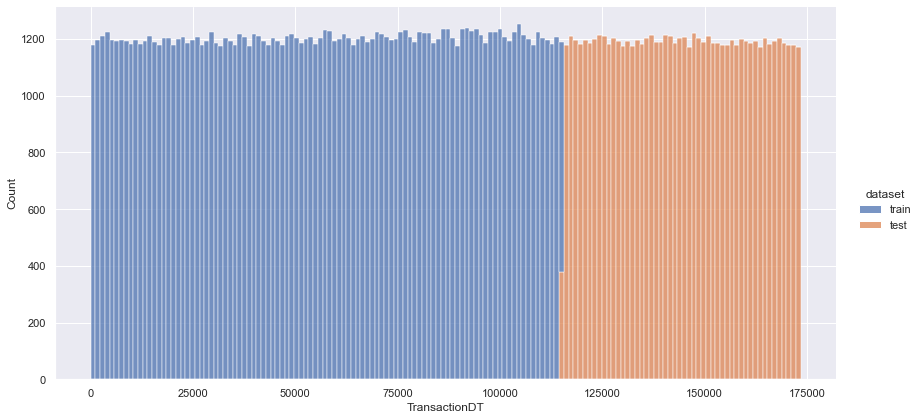

In [277]:
concatenated = pd.concat([X_train.assign(dataset='train'), X_test.assign(dataset='test')])
sns.displot(concatenated, x="TransactionDT", hue='dataset', multiple="stack", bins=150, height=6, aspect=16/8, fill=True)

In [278]:
X_train['TransactionDT'].max(), X_test['TransactionDT'].min()

(115257, 115258)

- Судя по графику, у трейна и теста есть пересечение по времени. Но, похоже, что дело в сжатом по бинам графике, а не в реальных данных.

In [279]:
params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.1,
    "reg_lambda": 100,
    "max_depth": 4,
    "gamma": 10,
    "nthread": 6,
    "seed": 27
}

In [281]:
dtrain = xgb.DMatrix(
    data=X_train, label=y_train
)
dvalid = xgb.DMatrix(
    data=X_test, label=y_test
)

In [282]:
%%time
model_xgb_ts = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    early_stopping_rounds=50,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    verbose_eval=10,
    maximize=True,
)

[0]	train-auc:0.60312	valid-auc:0.57286
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[10]	train-auc:0.77838	valid-auc:0.77655
[20]	train-auc:0.81622	valid-auc:0.80929
[30]	train-auc:0.86004	valid-auc:0.84270
[40]	train-auc:0.88125	valid-auc:0.84997
[50]	train-auc:0.89002	valid-auc:0.85801
[60]	train-auc:0.89636	valid-auc:0.86169
[70]	train-auc:0.90099	valid-auc:0.86425
[80]	train-auc:0.90523	valid-auc:0.86720
[90]	train-auc:0.90761	valid-auc:0.86844
[100]	train-auc:0.90963	valid-auc:0.86940
[110]	train-auc:0.91115	valid-auc:0.87060
[120]	train-auc:0.91274	valid-auc:0.87324
[130]	train-auc:0.91356	valid-auc:0.87369
[140]	train-auc:0.91356	valid-auc:0.87369
[150]	train-auc:0.91356	valid-auc:0.87369
[160]	train-auc:0.91356	valid-auc:0.87369
[170]	train-auc:0.91356	valid-auc:0.87369
Stopping. Best iteration:
[121]	train-auc:0.91287	valid-auc:0.87370

Wall time: 2min 20s


In [283]:
y_train_pred = model_xgb_ts.predict(dtrain)
y_valid_pred = model_xgb_ts.predict(dvalid)
y_lb_pred = model_xgb_ts.predict(dleaderboard)

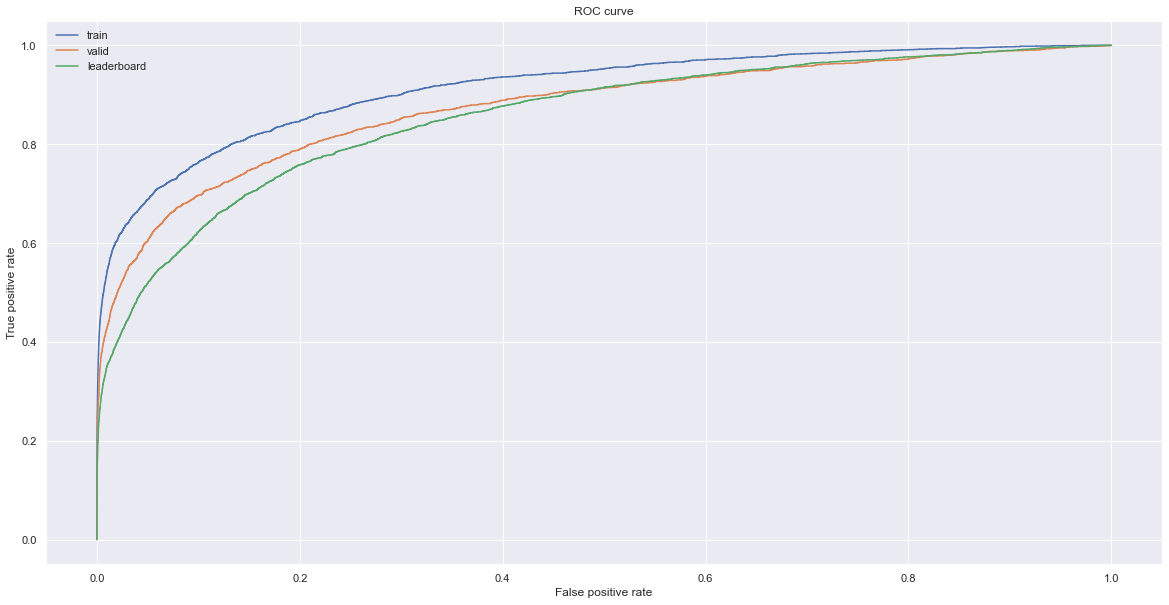

In [289]:
roc_curve_res = plot_roc_curve(
    train=(y_train, y_train_pred), 
    valid=(y_test, y_valid_pred), 
    leaderboard=(y_lb, y_lb_pred)
)

In [290]:
print(
    'Train', roc_auc_score(y_train, y_train_pred), 
    '\nValid', roc_auc_score(y_test, y_valid_pred), 
    '\nLeaderboard', roc_auc_score(y_lb, y_lb_pred)
)

Train 0.9135617186513473 
Valid 0.8736945385053512 
Leaderboard 0.8557171817839153


- Метрика качества на валидационной выборке близка к лидерборду, что говорит о менее переобученной моделе, чем в том же методе с обычным разбиением train_test_split

__Задание 7 (совсем опциональное):__ в данном наборе данных у нас есть ID-транзакции (TransactionID) и время транзакции (TransactionDT), но отсутствует ID-клиента, который совершал транзакции. Кажется, что в этой задаче валидация по клиенту работала бы хорошо. Предложить критерий, по которому можно выделить клиентов и сделать п.5, используя созданное определение клиента, используя валидацию по клиенту (GroupKFold).

- Похоже, что признак __card1__ содержит часть id карты пользователя, а вместе с признаками __card4__, __card6__ по ним можно точно идентифицировать отдельную карту. Будем считать что комбинация этих признаков определяет пользователя.

In [13]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,P_emaildomain_zone,R_emaildomain_zone,P_emaildomain_domain,R_emaildomain_domain
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,unknown,unknown,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,unknown,unknown,unknown,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unknown,unknown,unknown,unknown
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,unknown,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,unknown,unknown,unknown,M0,T,T,unknown,unknown,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [14]:
card_cols = ['card1', 'card4', 'card6']
all_groupby = train.groupby(card_cols, as_index=False).agg({'TransactionID': 'count'})
all_groupby.head(2)

,card1,card4,card6,TransactionID
0,1001,visa,debit,2
1,1004,visa,credit,2


In [15]:
all_groupby['user_id'] = all_groupby.index
all_groupby.drop('TransactionID', axis=1, inplace=True)
all_groupby.head(2)

,card1,card4,card6,user_id
0,1001,visa,debit,0
1,1004,visa,credit,1


In [16]:
train2 = pd.merge(train, all_groupby, on=card_cols, how='left')

In [17]:
train2.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,P_emaildomain_zone,R_emaildomain_zone,P_emaildomain_domain,R_emaildomain_domain,user_id
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,unknown,unknown,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,unknown,unknown,unknown,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unknown,unknown,unknown,unknown,7077
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,unknown,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,unknown,unknown,unknown,M0,T,T,unknown,unknown,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0

In [28]:
data = train2[num_features + dum_features + ['user_id']].apply(le().fit_transform)
y = train2[target]
groups = train2['user_id']

In [24]:
cv_strategy = GroupKFold(n_splits=5)

In [39]:
%%time
estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_cross_validation(
    data, y, xgb, metric=roc_auc_score, cv_strategy=cv_strategy, groups=groups
)

Fold: 1, train-observations = 143981, valid-observations = 35996
train-score = 0.9227, valid-score = 0.8886
Fold: 2, train-observations = 143981, valid-observations = 35996
train-score = 0.9258, valid-score = 0.88
Fold: 3, train-observations = 143982, valid-observations = 35995
train-score = 0.9198, valid-score = 0.8916
Fold: 4, train-observations = 143982, valid-observations = 35995
train-score = 0.9189, valid-score = 0.8908
Fold: 5, train-observations = 143982, valid-observations = 35995
train-score = 0.923, valid-score = 0.8857
CV-results train: 0.922 +/- 0.002
CV-results valid: 0.8873 +/- 0.004
OOF-score = 0.8876
Wall time: 18min 26s


- Валидация по GroupKFold оказалась на этом датасете действительно стабильнее всех остальных
- И даже результат на valid выборках оказался ближе к результату на лидерборде 0.86